In [1]:
%matplotlib inline
import networkx as nx
import metis
import random
from tqdm import tqdm
from itertools import chain
from matplotlib import pyplot as plt
from collections import Counter, defaultdict

In [2]:
GAMMA = 1.5

In [3]:
def get_alpha(g, k=2, gamma=GAMMA):
    return np.sqrt(k) * g.number_of_edges() / np.power(g.number_of_nodes(), GAMMA)

In [4]:
def attempt_reassignment(g, n, partition, node2cluster, gamma, alpha):    
    c_star = best_cluster_id(g, n, partition, gamma, alpha)
    did_it = False
    if node2cluster[n] != c_star:
        partition[node2cluster[n]].remove(n)
        partition[c_star].add(n)
        node2cluster[n] = c_star
        did_it = True
    return did_it, partition, node2cluster

def best_cluster_id(g, u, part, gamma, alpha):
    """part: dict(cluster_id, set of node)
             the partition information
        alpha, gamma: balancing parameter"""
    N_u = set(g.neighbors(u))
    def score(c):
        s = (len(part[c].intersection(N_u)) -
                alpha * gamma / 2 * np.power(len(part[c]), gamma-1))
        return s
    return max(part, key=score)

In [12]:
def update_partition(g, node_cluster_ids, k=2,
                     edges_to_add=[], edges_to_remove=[],
                     gamma=GAMMA,
                     verbose=True):
    """
    incrementally update the partitioning

    node_cluster_ids: list of cluster ids
    
    return:
        list of updated cluster ids
    """
    if len(edges_to_add) == 0 and len(edges_to_remove) == 0:
        print('nothing to update')
        return node_cluster_ids
    
    partition = defaultdict(set)  # cluster id to list of nodes
    for p, n in zip(node_cluster_ids, g.nodes_iter()):
        partition[p].add(n)
    node2cluster = dict(zip(g.nodes(), part))  # node to cluster id
    
    g.add_edges_from(edges_to_add)
    g.remove_edges_from(edges_to_remove)

    alpha = get_alpha(g, gamma=gamma)
    params = {'gamma': gamma, 'alpha': alpha}
    for u, v in tqdm(chain(edges_to_add, edges_to_remove)):
        if verbose:
            print('edge ({}, {})'.format(u, v))
        affected_nodes = set()
        did_it, partition, node2cluster = attempt_reassignment(g, u,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(u))
            affected_nodes |= set(g.neighbors(u))
        did_it, partition, node2cluster = attempt_reassignment(g, v,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(v))
            affected_nodes |= set(g.neighbors(v))

        for n in affected_nodes:
            if True:
                did_it, partition, node2cluster = attempt_reassignment(
                    g, n, partition, node2cluster, **params)
                if verbose:
                    if did_it:
                        print('moved node {}'.format(n))      
                    else:
                        print('{} stayed'.format(n))

    return [node2cluster[n] for n in g.nodes_iter()]

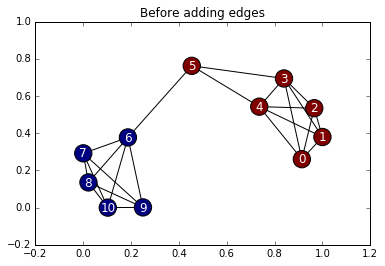

In [6]:
g = nx.barbell_graph(5, 1)
g.add_edge(3, 5)

_, part = metis.part_graph(g, 2)

nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('Before adding edges')

2it [00:00, 4297.44it/s]

edge (5, 7)
moved node 5
8 stayed
3 stayed
4 stayed
6 stayed
7 stayed
edge (5, 8)


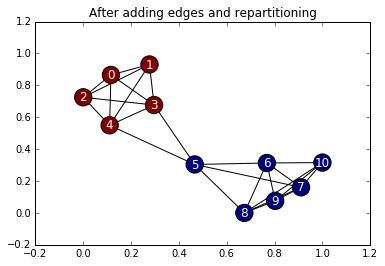

In [7]:
part = update_partition(g, node_cluster_ids=part, edges_to_add=[(5, 7), (5, 8)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After adding edges and repartitioning')

2it [00:00, 5246.16it/s]

edge (5, 7)
moved node 5
3 stayed
4 stayed
6 stayed
edge (5, 8)


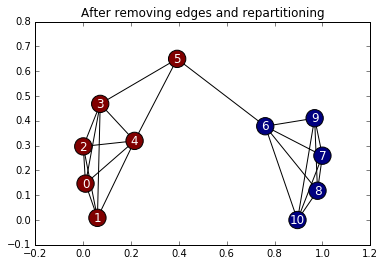

In [8]:
part = update_partition(g, node_cluster_ids=part, edges_to_remove=[(5, 7), (5, 8)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After removing edges and repartitioning')

In [9]:
def performance(g, updated_cluster_ids, raw_cuts, raw_cluster_ids):
    partition = defaultdict(set)
    for n, c in zip(g.nodes_iter(), part):
        partition[c].add(n)

    c1, c2 = list(partition.values())
    cuts = 0
    for u, v in tqdm(g.edges_iter()):
        if (u in c1 and v in c2) or (u in c2 and v in c1):
            cuts += 1
    r1 = cuts / g.number_of_edges()
    size_1 = (len(c1), len(c2))
    
    r2 = raw_cuts / g.number_of_edges()     
    size_2 = tuple(Counter(raw_cluster_ids).values())
    return {'ratio': (r1, r2),
            'size': (size_1, size_2)}

In [10]:
cuts, raw_parts = metis.part_graph(g, 2)
performance(g, part, cuts, raw_parts)

23it [00:00, 246723.76it/s]


{'ratio': (0.043478260869565216, 0.043478260869565216),
 'size': ((5, 6), (5, 6))}

In [13]:
# Experiment on real networks
from glob import glob
from time import time


rows = []
for path in tqdm(glob('data/*.gpkl')):
    print(path)
    g = nx.read_gpickle(path)
    _, parts = metis.part_graph(g, 2)
    s = time()
    updated_parts = update_partition(g, node_cluster_ids=parts, verbose=False)
    takes_time_1 = time() - s
    
    s = time()
    raw_cuts, raw_parts = metis.part_graph(g, 2)
    takes_time_2 = time() - s
    
    stat = performance(g, updated_parts, raw_cuts, raw_parts)
    stat['name'] = path
    stat['running_time'] = (takes_time_1, takes_time_2)
    rows.append(stat)

  0%|          | 0/8 [00:00<?, ?it/s]

data/circular.gpkl
nothing to update



0it [00:00, ?it/s]
 12%|█▎        | 1/8 [00:01<00:10,  1.54s/it]

data/barbell_1000_0.gpkl
nothing to update



0it [00:00, ?it/s]
124330it [00:00, 1243298.22it/s]
242892it [00:00, 1225413.44it/s]
365250it [00:00, 1224860.55it/s]
478866it [00:00, 1196828.90it/s]
597356it [00:00, 1193222.85it/s]
695905it [00:00, 1110778.00it/s]
815687it [00:00, 1135469.91it/s]
939429it [00:00, 1164245.06it/s]
 25%|██▌       | 2/8 [00:11<00:24,  4.10s/it]

data/mtvhottest.gpkl
nothing to update



0it [00:00, ?it/s]
81060it [00:00, 810598.84it/s]
 38%|███▊      | 3/8 [00:15<00:20,  4.04s/it]

data/star.gpkl
nothing to update



0it [00:00, ?it/s]
 50%|█████     | 4/8 [00:16<00:12,  3.24s/it]

data/beefban.gpkl
nothing to update



0it [00:00, ?it/s]
 62%|██████▎   | 5/8 [00:18<00:07,  2.64s/it]

data/baltimore.gpkl
nothing to update



0it [00:00, ?it/s]
105603it [00:00, 1056015.90it/s]
 75%|███████▌  | 6/8 [00:23<00:06,  3.31s/it]

data/ukraine.gpkl
nothing to update



0it [00:00, ?it/s]
94542it [00:00, 945411.89it/s]
 88%|████████▊ | 7/8 [00:26<00:03,  3.29s/it]

data/barabasi.gpkl
nothing to update



0it [00:00, ?it/s]
121019it [00:00, 1210173.84it/s]
100%|██████████| 8/8 [00:29<00:00,  3.22s/it]


In [14]:
rows

[{'name': 'data/circular.gpkl',
  'ratio': (2e-05, 4e-05),
  'running_time': (0.0002791881561279297, 0.553736686706543),
  'size': ((5, 6), (25000, 25000))},
 {'name': 'data/barbell_1000_0.gpkl',
  'ratio': (3.002999996997e-05, 1.000999998999e-06),
  'running_time': (0.0008504390716552734, 4.043878555297852),
  'size': ((5, 6), (1000, 1000))},
 {'name': 'data/mtvhottest.gpkl',
  'ratio': (0.0, 0.005716931566911723),
  'running_time': (0.0001819133758544922, 1.363112211227417),
  'size': ((5, 6), (31898, 31437))},
 {'name': 'data/star.gpkl',
  'ratio': (0.0001, 0.485),
  'running_time': (0.0006005764007568359, 0.5381162166595459),
  'size': ((5, 6), (24250, 25751))},
 {'name': 'data/beefban.gpkl',
  'ratio': (0.0, 0.04667154352596928),
  'running_time': (0.0003304481506347656, 0.4363102912902832),
  'size': ((5, 6), (13681, 14504))},
 {'name': 'data/baltimore.gpkl',
  'ratio': (0.0, 0.07997247075017205),
  'running_time': (0.0007874965667724609, 1.9379253387451172),
  'size': ((5, 6), (